### Введение
Рассматриваем нейронную сеть с вариационными слоями. 

Network loss: $L^N(w, D) = - \ln p(D|w)$.

Variational free energy: $F = -\left\langle \ln\dfrac{p(D|w)p(w|\alpha)}{q(w|\beta)} \right\rangle_{w \sim q(\beta)} = \left\langle L^N(w, D)\right\rangle_{w \sim q(\beta)} + D_{KL}(q(\beta)||p(\alpha)) \rightarrow \min$.

В статье предлагается эвристика сокращения весов сети. Чем более вероятен вес $w \sim q(\beta)$, тем меньший вклад он вносит в $L^N(w, D)$, поэтому можно его удалить (занулить). Критерий удаления (normal prior):

$$\exp\left(-\dfrac{\mu^2_i}{2\sigma^2_i}\right) > \gamma \Rightarrow \left|\dfrac{\mu_i}{\sigma_i}\right| < \lambda$$

### Импортируем все нужные библиотеки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.init as init
import math

In [2]:
device = 'cpu' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

### Инициализация параметров

In [3]:
init_log_sigma = -2.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = 1.0 # априорная дисперсия
epoch_num = 15 #количество эпох
hidden_num = 20
batch_size = 256

In [4]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)


Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw


Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw
Processing...
Done!


/home/nick/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Функция обучения

In [5]:
def train(net, loss_fn, optimizer):
    losses = []
    for x,y in train_loader:            
        x = x.to(device)
        y = y.to(device)          
        optimizer.zero_grad()  
        loss = 0                
        out = net(x)
        loss = loss + loss_fn(out, y)
        loss += net.KLD()/len(train_data)
        loss.backward()       
        clip_grad_value_(net.parameters(), 1.0) # для стабильности градиента. С этим можно играться
        optimizer.step()
    

### Код для вариационной нейронной сети. В общем случае можно делать много слоев, мы же будеи использовать один. 


In [6]:
MIN_SIGMA = 1e-5 # чтобы было все хорошо в распределении
    
class VarLayer(nn.Module): # вариационная однослойная сеть
    def __init__(self, in_,  out_,   prior_sigma = 1.0, init_log_sigma=-3.0, act=F.relu):         
        nn.Module.__init__(self)                    
        self.mean = nn.Parameter(t.randn(in_, out_)) # параметры средних
        t.nn.init.xavier_uniform_(self.mean) 
        self.log_sigma = nn.Parameter(t.ones(in_, out_)*init_log_sigma) # логарифм дисперсии
        self.mean_b = nn.Parameter(t.randn(out_)) # то же самое для свободного коэффициента
        self.log_sigma_b = nn.Parameter(t.ones(out_) * init_log_sigma)
                
        self.in_ = in_
        self.out_ = out_
        self.act = act
        self.prior_sigma = prior_sigma
        
    def forward(self,x):
        if self.training: # во время обучения - сэмплируем из нормального распределения
            self.eps_w = t.distributions.Normal(self.mean, MIN_SIGMA+t.exp(self.log_sigma))
            self.eps_b = t.distributions.Normal(self.mean_b, MIN_SIGMA+t.exp(self.log_sigma_b))
        
            w = self.eps_w.rsample()
            b = self.eps_b.rsample()
             
        else:  # во время контроля - смотрим средние значения параметра        
            w = self.mean 
            b = self.mean_b   
        # функция активации         
        return self.act(t.matmul(x, w)+b)

    def KLD(self, prior_scale=1.0):
        size = self.mean.shape
        out = self.mean_b.shape
        # подсчет дивергенции        
        device = self.mean.device
        self.eps_w = t.distributions.Normal(self.mean, MIN_SIGMA+t.exp(self.log_sigma))
        self.eps_b = t.distributions.Normal(self.mean_b,  MIN_SIGMA+t.exp(self.log_sigma_b))     
        self.h_w = t.distributions.Normal(t.zeros(size, device=device), prior_scale*self.prior_sigma * t.ones(size, device=device))
        self.h_b = t.distributions.Normal(t.zeros(out, device=device), prior_scale*self.prior_sigma * t.ones(out, device=device))  
        k1 = t.distributions.kl_divergence(self.eps_w,self.h_w).sum()        
        k2 = t.distributions.kl_divergence(self.eps_b,self.h_b).sum()        
        return k1+k2
    
    
#Обертка для нескольких вариационных слоев
class VarNet(nn.Sequential):    
    def KLD(self, prior_scale = 1.0):
        k = 0
        for l in self: 
            k+=l.KLD(prior_scale = prior_scale)              
        return k
    
    def forward(self, x):
        for l in self:
            x = l(x)
        return x
    

In [7]:
def test_acc(net): # точность классификации
    acc = []    
    correct = 0
    net.eval() 
    for x,y in test_loader: 
        x = x.to(device)
        y = y.to(device)  
        out = net(x)    
        correct += out.argmax(1).eq(y).sum().cpu().numpy()
    acc = (correct / len(test_data))

    return acc

### Обучаем модель

In [8]:
#Сеть 20 скрытых нейронов
net = VarNet(VarLayer(784,  20, 
                                prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                     VarLayer(20, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                              act=lambda x:x))
net = net.to(device)
optim = t.optim.Adam(net.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss().to(device)            
for e in range(epoch_num):     
    train(net, loss_fn, optim)
    print("Эпоха {}.Точность модели".format(e), test_acc(net))

/home/nick/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Эпоха 0.Точность модели 0.2062
Эпоха 1.Точность модели 0.4839
Эпоха 2.Точность модели 0.6578
Эпоха 3.Точность модели 0.7132
Эпоха 4.Точность модели 0.7666
Эпоха 5.Точность модели 0.7997
Эпоха 6.Точность модели 0.8172
Эпоха 7.Точность модели 0.8256
Эпоха 8.Точность модели 0.8308
Эпоха 9.Точность модели 0.8357
Эпоха 10.Точность модели 0.8396
Эпоха 11.Точность модели 0.8463
Эпоха 12.Точность модели 0.8555
Эпоха 13.Точность модели 0.8633
Эпоха 14.Точность модели 0.8669


In [10]:
final_acc = [test_acc(net)]

### Для каждого значения lambda проведем удаление параметров. Если значения параметров меньше или равны нашего трешхолда lambda -- удаляем. 

In [11]:
lam = 0.05
layer_num = 2
acc_delete = []
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

In [12]:
final_acc.append(test_acc(net))

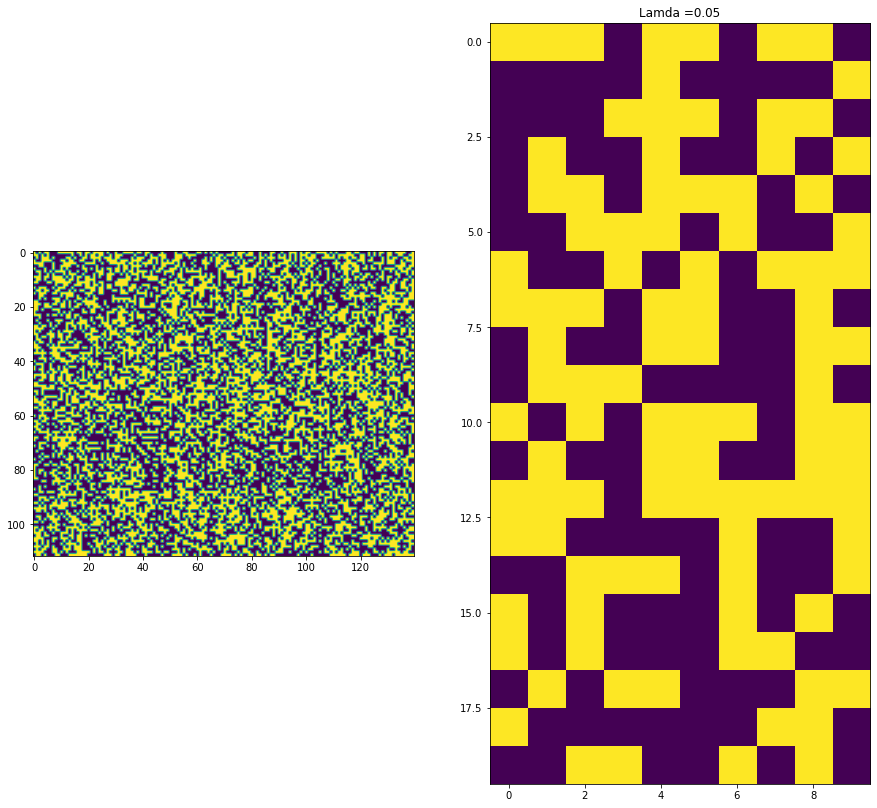

In [13]:
plt.rcParams['figure.figsize'] =(15, 20)
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


In [14]:
lam = 0.1
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

In [15]:
final_acc.append(test_acc(net))

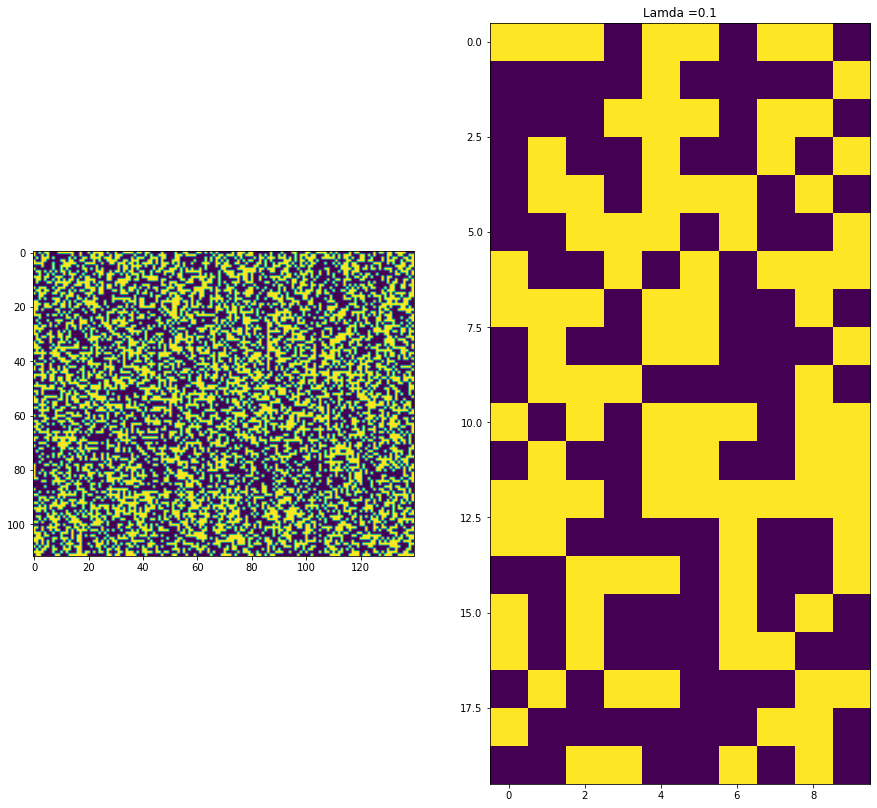

In [16]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


In [17]:
lam = 0.2
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

In [18]:
final_acc.append(test_acc(net))

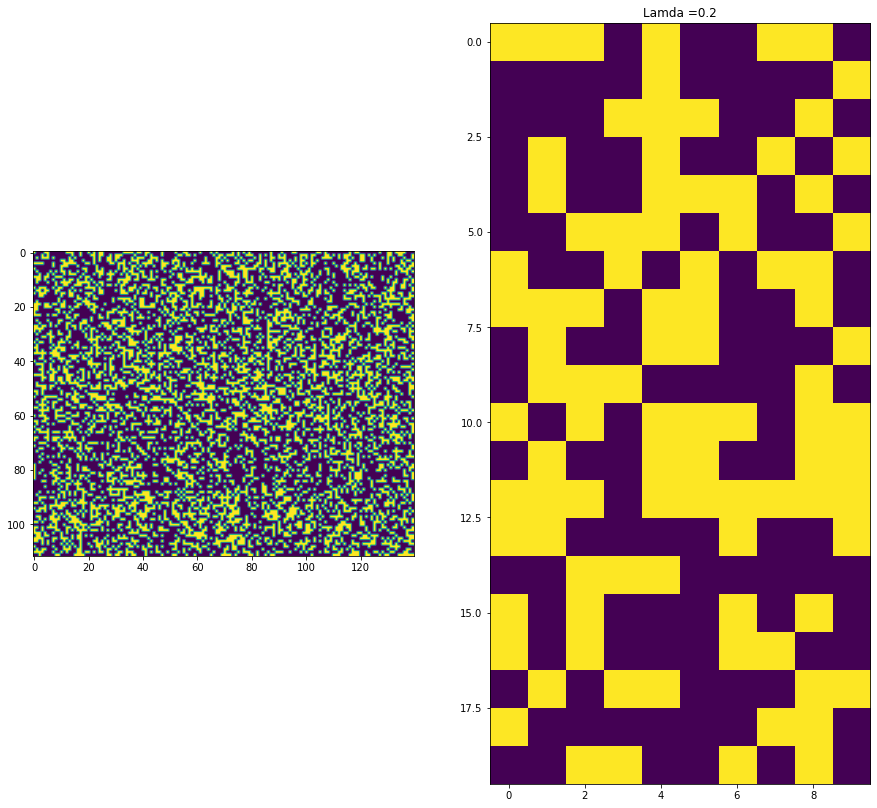

In [19]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()

In [20]:
lam = 0.5
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

In [21]:
final_acc.append(test_acc(net))

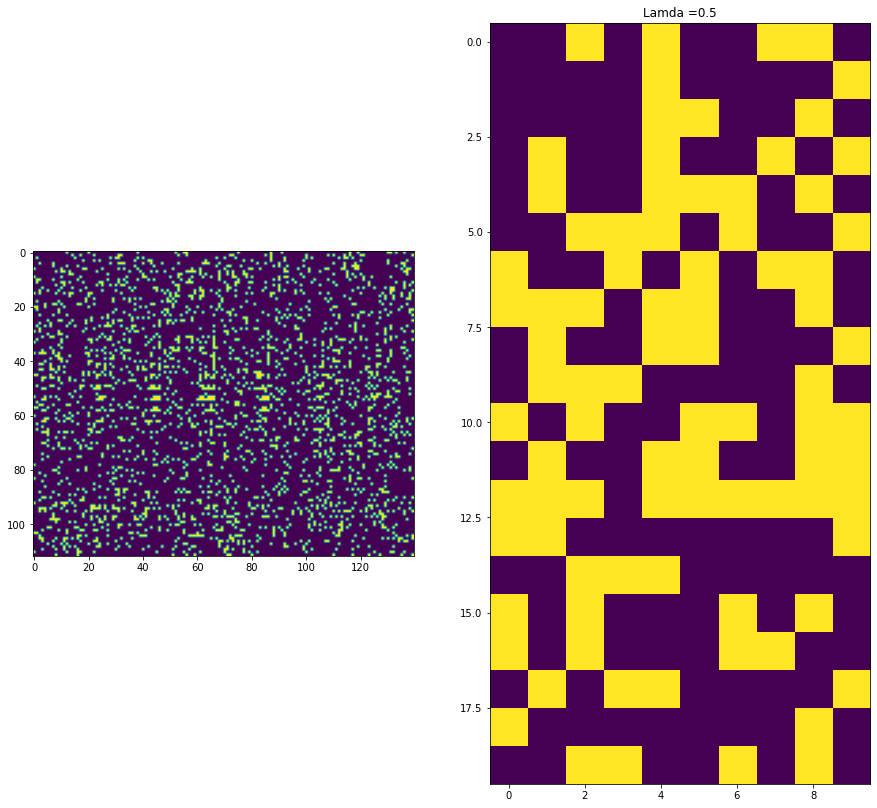

In [22]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()

In [23]:
lam = 1
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

In [24]:
final_acc.append(test_acc(net))

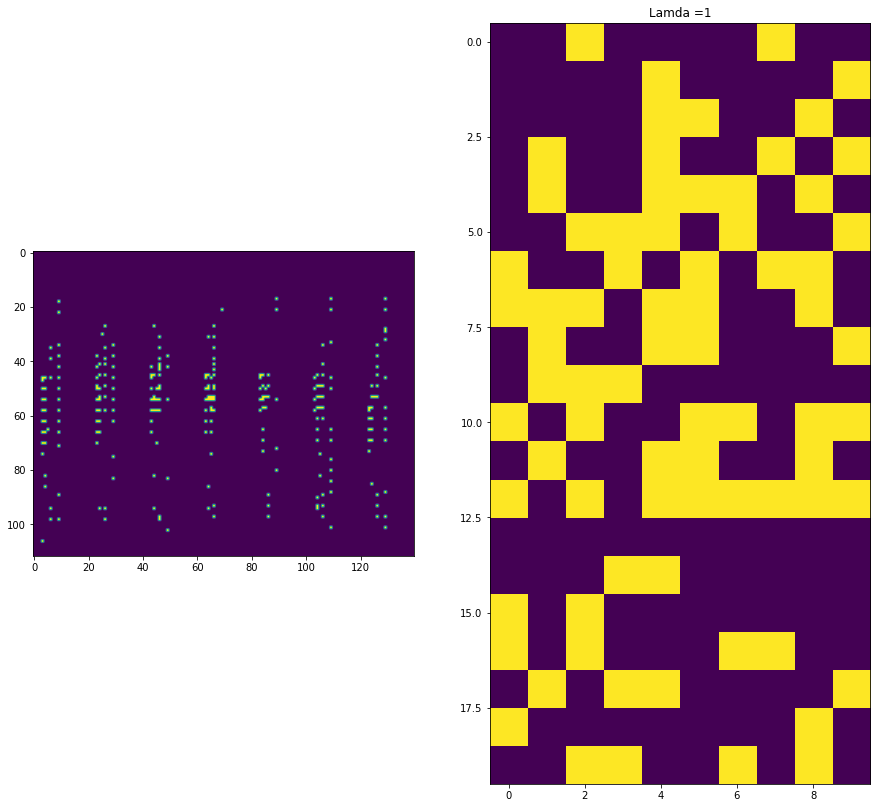

In [25]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


In [26]:
lam = 2
layer_num = 2
prune_coefs = []
for l in range(layer_num):
    mu = net[l].mean
    sigma = t.exp(net[l].log_sigma) 
    res = t.abs(mu/sigma).cpu().detach().numpy()    
    prune_coefs.append(res)

for l in range(layer_num):
    prune_coef = prune_coefs[l]
    ids = (prune_coef <= lam) 
    net[l].mean.data*=(1-t.tensor(ids*1.0, device=device, dtype=t.float))  

In [27]:
final_acc.append(test_acc(net))

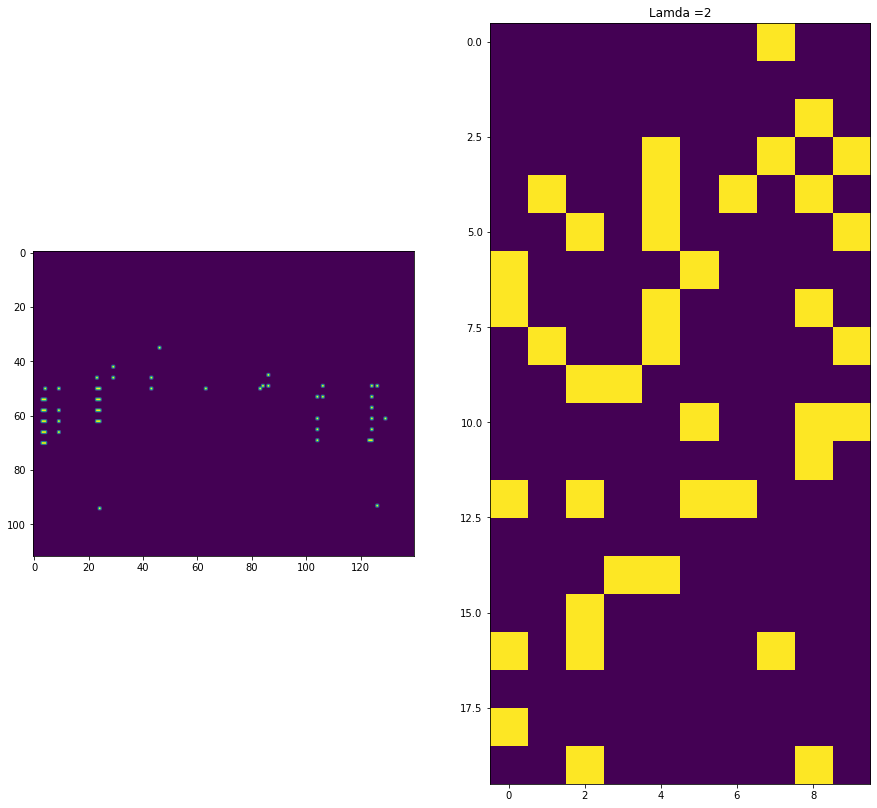

In [28]:
a = net[0].mean.data.flatten().cpu()
a = t.where(a>0, 1, 0)
b = net[1].mean.data.flatten().cpu()
b = t.where(b>0, 1, 0)
a = a.reshape(112, -1)
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(a)
ax2.imshow(b.reshape(20, 10))
plt.title("Lamda ={}".format(lam))
plt.show()


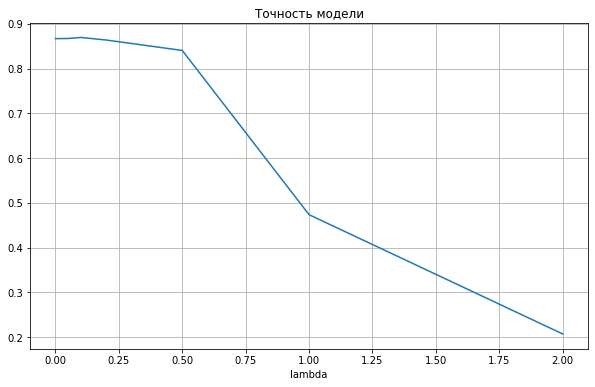

In [35]:
plt.figure(figsize=(10, 6))
plt.plot([0, 0.05, 0.1, 0.2, 0.5, 1, 2], final_acc)
plt.title("Точность модели")
plt.xlabel("lambda")
plt.grid()
plt.show()